# Zindi CGIAR Root Volume Challenge

As depicted in the picture below, a single cassava plant can have more than one root. The term root volume therefore refers to the total volume of the identified roots of a given plant. In this image, there are at least six roots (labeled from 1 to 6) on the plant.

![](https://zindi-public-release.s3.eu-west-2.amazonaws.com/uploads/image_attachment/image/2559/358c9a4b-527c-4fff-8ff1-725e89510cfd.jpg)

Each folder contains images for the roots of cassava plants generated for the left and right scans at different depths or layers. A Ground Penetrating Radar is used to non-invasively scan the roots of the cassava plants from each side. The raw data collected by the radar is then processed into images. Seven plants are scanned from both sides (left & right) at any given time. This implies that the maximum number of plants in any given image is 7. However this does not mean that all the 7 plants will always be visible in the image of the corresponding scan. The naming convention for images follows this format: XXXXXXXX_S_NNN.png. The characters in the pattern XXXXXXXX consist of random characters. This information is not relevant to you for this project. The S is the side of the scan. It can be L (left) or R (right) depending on the side from which the scan is performed. The three last characters in the image name are digits. These digits correspond to the depth or layer of the scan. Examples of images found in a folder are XXXXXX_L_001.png, XXXXXXXX_R_001.png, XXXXXXX_L_102.png, and XXXXXXXX_R_102.png. In this instance, there are 204 images in the folder; 102 images for each side with layers ranging from 1 up to 102. No assumption should be made about each folder having the same number of images since a different range of layers may be used.

**More about the Competition [here](https://zindi.africa/competitions/cgiar-root-volume-estimation-challenge)**

### PS If you find this notebook helpful, please consider giving it an upvote. Otherwise let's dive into the more interesting part

# 🌱 Understanding the Competition 🚀  

This competition presents a **unique challenge**, and I truly appreciate the effort the organizers have put into designing it! 🎯 Before jumping into coding, let’s take a step back and **understand the task**.  

## 🔍 What is Ground Penetrating Radar (GPR)?  

The dataset in this competition was collected using **Ground Penetrating Radar (GPR)**. Never heard of GPR before? 🤔 Don't worry, I was also confused at first! So, I checked out a few YouTube videos, and this one does a great job explaining how it works:  

[![🎥 Video Thumbnail](https://img.youtube.com/vi/VIDEO_ID/0.jpg)](https://www.youtube.com/watch?v=MfpUA05s0GU)  

After watching the video, the **images in the dataset start to make a lot more sense**! 🎉  

---

## 🏆 Understanding the Task  

Each folder in the dataset contains **GPR-scanned images** of cassava plant roots, captured from the **left and right** sides at different depths. 🌿 The scans are processed from raw radar data, allowing us to **analyze root structures without digging up the plants**. 🛠️  

At most, an image may contain **up to 7 plants**, though not all may be visible in every scan. 👀  

### 🎯 Our mission:  

1️⃣ **Segment the root data** – Identify and extract root structures from the GPR images.  
2️⃣ **Estimate the root volume** – Use the segmented roots to predict the **total root volume** of each cassava plant.  

Since this is a **starter notebook**, we will begin by using the **pre-trained segmentation models** provided by the organizers. These models are:  

✅ `best_early.pt` – Trained on **early-stage** cassava root data.  
✅ `best_late.pt` – Trained on **late-stage** cassava root data.  
✅ `best_full.pt` – Trained on data from **both growth stages**.  

You can **use these models**, **fine-tune them**, or **develop your own** from scratch! 💡 The choice is yours!  

---

## 📂 Dataset Insights  

🔹 The images follow the naming pattern: **`XXXXXXXX_S_NNN.png`**, where:  
   - `XXXXXXXX` ➝ Random identifier (not relevant to the task).  
   - `S` ➝ Scan **side** (`L` = Left, `R` = Right).  
   - `NNN` ➝ **Depth** layer (e.g., `001`, `052`, `102`).  

🔹 **Left and right images** do not always have the same dimensions. 📏  
🔹 **Root visibility varies** at different depths, so choosing the right images is **critical**!  
🔹 A **CSV file** provides suggested image ranges, but you're free to experiment.

---

## 🚀 Next Steps  

Now that we understand the task, let’s **load the data** and run the provided models to get our **first results**! 🎉  

🔹 **Step 1:** Load the dataset   
🔹 **Step 2:** Run the segmentation models <br>
🔹 **Step 3:** Generate a new dataset <br>
🔹 **Step 4:** Train a new Model on this generated dataset <br>
🔹 **Step 5:** Run Inference, submit

Let’s dive in! 🔥🚀  


# Import the Libraries

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np #type:ignore
import pandas as pd # type:ignore
from PIL import Image #type:ignore
from pathlib import Path
from ultralytics import YOLO #type:ignore
import matplotlib.pyplot as plt #type:ignore
import cv2 #type:ignore
import os
from typing import List
import re
from tqdm import tqdm #type:ignore
import lightning as L #type:ignore
from torch.utils.data import DataLoader, Dataset #type:ignore
import torch #type:ignore
from torchvision.transforms import v2 #type:ignore
from torch import nn #type:ignore

# Load the data

In [4]:
TRAIN_DATA_PATH = Path("data/train")
TEST_DATA_PATH = Path("data/test")

In [5]:
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")
submission_df = pd.read_csv("Sample_Submission.csv")

In [ ]:
train_df.head()

In [ ]:
test_df.head()

In [ ]:
test_df.shape, train_df.shape, submission_df.shape

In [ ]:
submission_df.head()

In [ ]:
train_df['Stage'].value_counts()

In [ ]:
test_df['Stage'].value_counts()

In [ ]:
train_df['FolderName'].unique().size, test_df['FolderName'].unique().size

In [ ]:
folder = "Ypktwvqjbn"
df = train_df[train_df['FolderName'] == folder]

df[['FolderName', 'PlantNumber', 'Side', 'Start', 'End', 'RootVolume']].head(n = 10)

In [ ]:
len(os.listdir("/kaggle/input/zindi-cgiar-root-volume-estimation-challenge/data/test/A6dzrkjqvl"))

# Load the segmentation models

In [7]:
# Since the organizers didn't provide performance metrics, we will be using all the models (For Now)
segmentation_models = {
    "full" : YOLO("Models/Models/best_full.pt"),
    "early" : YOLO("Models/Models/best_early.pt"),
    "late" : YOLO("Models/Models/best_late.pt")
}

In [9]:
sample = "data/train/A2miww5mfx/A2miww5mfx_L_014.png"

seg_model = segmentation_models['early']
results = seg_model(sample)


image 1/1 c:\Users\Reinhard\Documents\computer_vision_projects\root_volume_estimation_challenge\data\train\A2miww5mfx\A2miww5mfx_L_014.png: 32x640 2 roots, 1510.5ms
Speed: 25.3ms preprocess, 1510.5ms inference, 63.1ms postprocess per image at shape (1, 3, 32, 640)


In [10]:
sample_image = Image.open(sample)
sample_image

'RGBA'

define the function ti get image data and image labels, geberate random colors for image visualization
pare the label file and extrCt polygon coordinates.

draw masks with unique colors 
return the requires polygons

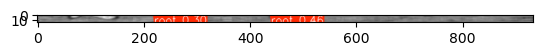

In [12]:
img = results[0].plot()
plt.imshow(img)

In [ ]:
for result in results:
    for box in result.boxes.xywh:
        x, y, w, h = box  # x, y are center coordinates
        print(f"Bounding Box - X: {x}, Y: {y}, Width: {w}, Height: {h}")

In [ ]:
segmentation_models.keys()

In [13]:

def get_segmented_images(image_paths, display_image=False):
    """Extracts and merges segments from images, returning only images with detections."""

    for model in segmentation_models.keys():
        model = segmentation_models[model]
        results = model(image_paths, verbose=False)

        if len(results[0].boxes.xyxy) != 0:
            break

    if len(results[0].boxes.xyxy) == 0:
        # Incase of no detections, return all the images (Still thinking of better ways to overcome this)
        return [Image.open(img) for img in image_paths]
        
    segmented_images = []
    
    for img_path, result in zip(image_paths, results):
        original_image = Image.open(img_path)
        merged_image = Image.new("RGBA", original_image.size, (0, 0, 0, 0))
        
        # Skip if no detections
        if len(result.boxes.xyxy) == 0:
            continue 
            
        # Extract and paste segments
        for box in result.boxes.xyxy:
            x1, y1, x2, y2 = map(int, box.tolist())
            segment = original_image.crop((x1, y1, x2, y2))
            merged_image.paste(segment, (x1, y1))
            
        segmented_images.append(merged_image)

    # Display Images
    if display_image and segmented_images:
        fig, axes = plt.subplots(1, len(segmented_images), figsize=(15, 10))
        if len(segmented_images) == 1:
            axes = [axes]
        for ax, img in zip(axes, segmented_images):
            ax.imshow(img)
            ax.axis("off")
        plt.show()

    return segmented_images

**Explanation** <br>
We are going to use `get_segmented_images` function to process a set of images and extracts the regions of interest (i.e., root segments) using a pre-trained segmentation models. It then returns the segmented images where roots are detected, or all images if no detections are made.

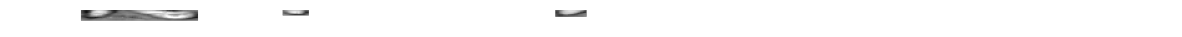

[<PIL.Image.Image image mode=RGBA size=934x14>]

In [15]:
get_segmented_images([sample], display_image = True)

In [16]:
# The function retrieves images from a specified folder
# based on the scan side (left or right) and a layer range
# (from a starting layer to an ending layer).

def get_images_within_range(base_path: Path, folder: str, side: str, start: int, end: int) -> list[Path]:
    """
    Get images from a folder that match the specified side (L/R) and layer range.
    
    Args:
        base_path: Root directory containing all folders
        folder: Name of the target folder (e.g., 'Ypktwvqjbn')
        side: Scan side to filter ('L' or 'R')
        start: Starting layer (inclusive)
        end: Ending layer (inclusive)
    """
    folder_path = base_path / folder
    
    # Get all files in the folder
    try:
        images = os.listdir(folder_path)
    except FileNotFoundError:
        return []

    # Regex pattern to extract side and layer from filenames
    pattern = re.compile(r'_([LR])_(\d{3})\.png$')
    
    selected_images = []
    
    for img_name in images:
        match = pattern.search(img_name)
        if match:
            # Extract side and layer from filename
            img_side = match.group(1)
            layer = int(match.group(2))
            
            # Check if matches criteria
            if img_side == side and start <= layer <= end:
                selected_images.append(folder_path / img_name)
    
    return selected_images

In [17]:
# test and see
sample_images = get_images_within_range(TRAIN_DATA_PATH, "Ypktwvqjbn", "L", 33, 41)
sample_images

[WindowsPath('data/train/Ypktwvqjbn/Ypktwvqjbn_L_033.png'),
 WindowsPath('data/train/Ypktwvqjbn/Ypktwvqjbn_L_034.png'),
 WindowsPath('data/train/Ypktwvqjbn/Ypktwvqjbn_L_035.png'),
 WindowsPath('data/train/Ypktwvqjbn/Ypktwvqjbn_L_036.png'),
 WindowsPath('data/train/Ypktwvqjbn/Ypktwvqjbn_L_037.png'),
 WindowsPath('data/train/Ypktwvqjbn/Ypktwvqjbn_L_038.png'),
 WindowsPath('data/train/Ypktwvqjbn/Ypktwvqjbn_L_039.png'),
 WindowsPath('data/train/Ypktwvqjbn/Ypktwvqjbn_L_040.png'),
 WindowsPath('data/train/Ypktwvqjbn/Ypktwvqjbn_L_041.png')]

In [18]:
get_segmented_images(sample_images, display_image = True)

[<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>]

In [19]:
# finally merge all of the image segments into one
def merge_segmented_images(path: Path, folder: str, side: str, start: int, end: int):
    images_in_range = get_images_within_range(path, folder, side, start, end)
    segmented_images = get_segmented_images(images_in_range)

    # Determine final dimensions for the merged image
    total_width = sum(img.width for img in segmented_images)  # Sum of all widths
    max_height = max(img.height for img in segmented_images)  # Max height among all images

    # Create a blank canvas with a transparent background
    merged_image = Image.new("RGBA", (total_width, max_height), (0, 0, 0, 0))

    # Paste each segmented image next to the previous one (left to right)
    x_offset = 0
    for img in segmented_images:
        merged_image.paste(img, (x_offset, 0), img)  # Paste at correct position
        x_offset += img.width  # Move x-offset to the right for the next image

    return merged_image

In [20]:
merged_image = merge_segmented_images(TRAIN_DATA_PATH, "Ox18ob0syv", "R", 21, 28)
merged_image

In [21]:
OUTPUT_IMAGE_DIR = Path("C:/Users/Reinhard/Documents/computer_vision_projects/root_volume_estimation_challenge/merged_images/")
os.makedirs(OUTPUT_IMAGE_DIR, exist_ok = True)

TRAIN_OUTPUT_DIR = OUTPUT_IMAGE_DIR / "Train"
TEST_OUTPUT_DIR = OUTPUT_IMAGE_DIR / "Test"

os.makedirs(TRAIN_OUTPUT_DIR, exist_ok = True)
os.makedirs(TEST_OUTPUT_DIR, exist_ok = True)

In [23]:
train_df.head()

,ID,FolderName,PlantNumber,Side,Start,End,RootVolume,Genotype,Stage
0,ID_826322_Lbmaya,A6dzrkjqvl,3,L,33,42,0.9,IITA-TMS-IBA000070,Early
1,ID_718181_Bslpwx,Ypktwvqjbn,7,L,33,41,1.5,IBA154810,Early
2,ID_465762_L1n61d,Ox18ob0syv,4,R,21,28,2.7,IBA980581,Early
3,ID_626872_Pbmx2e,Hqcekwpxgu,2,R,30,39,2.6,IITA-TMS-IBA000070,Early
4,ID_518846_Opko8c,Ummqfuetoc,1,R,17,26,2.7,IBA980581,Early


# Generate the new dataset

In [24]:
# Iterate through all the  images in the df
def generate_merged_images(df: pd.DataFrame, output_path: Path, input_path: Path):
    gen_image_paths = []
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Merging Images"):
        gen_image = merge_segmented_images(
            path=input_path,
            folder=row["FolderName"],
            side=row["Side"],
            start=row["Start"],
            end=row["End"]
        )
        img_path = output_path / f"{row['ID']}.png"
        gen_image.save(img_path)
        gen_image_paths.append(img_path)

    df['image segments'] = gen_image_paths
    return df

In [25]:
new_train_df = generate_merged_images(train_df, TRAIN_OUTPUT_DIR, TRAIN_DATA_PATH)

Merging Images: 100%|██████████| 386/386 [41:45<00:00,  6.49s/it]


In [26]:
new_train_df.head()

,ID,FolderName,PlantNumber,Side,Start,End,RootVolume,Genotype,Stage,image segments
0,ID_826322_Lbmaya,A6dzrkjqvl,3,L,33,42,0.9,IITA-TMS-IBA000070,Early,C:\Users\Reinhard\Documents\computer_vision_pr...
1,ID_718181_Bslpwx,Ypktwvqjbn,7,L,33,41,1.5,IBA154810,Early,C:\Users\Reinhard\Documents\computer_vision_pr...
2,ID_465762_L1n61d,Ox18ob0syv,4,R,21,28,2.7,IBA980581,Early,C:\Users\Reinhard\Documents\computer_vision_pr...
3,ID_626872_Pbmx2e,Hqcekwpxgu,2,R,30,39,2.6,IITA-TMS-IBA000070,Early,C:\Users\Reinhard\Documents\computer_vision_pr...
4,ID_518846_Opko8c,Ummqfuetoc,1,R,17,26,2.7,IBA980581,Early,C:\Users\Reinhard\Documents\computer_vision_pr...


In [27]:
new_train_df['RootVolume'] = new_train_df.groupby('FolderName')['RootVolume'].transform('mean')

In [28]:
new_test_df = generate_merged_images(test_df, TEST_OUTPUT_DIR, TEST_DATA_PATH)

Merging Images: 100%|██████████| 130/130 [11:10<00:00,  5.16s/it]


In [29]:
def display_generated_images(image_paths):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()

    for i, img_path in enumerate(image_paths[:4]):  # Display first 4 images
        image = Image.open(img_path)
        axes[i].imshow(image)
        axes[i].axis("off")  # Hide axes
        axes[i].set_title(f"Image {i+1}")

    plt.tight_layout()
    plt.show()

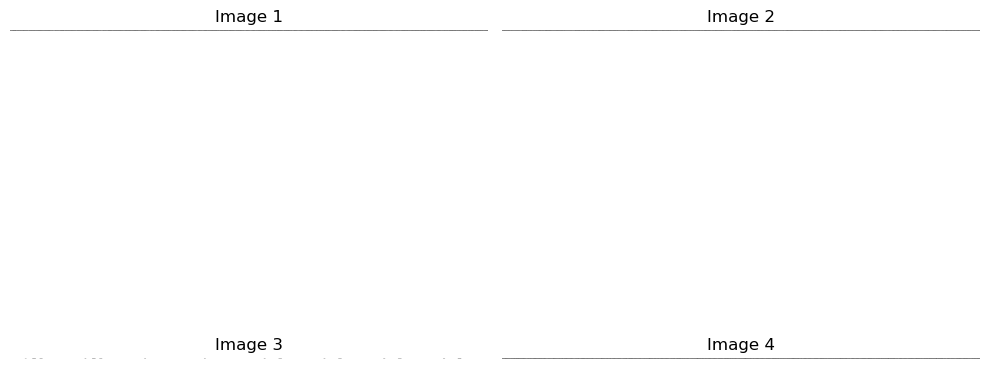

In [30]:
# Display Train

display_generated_images(new_train_df['image segments'].values)

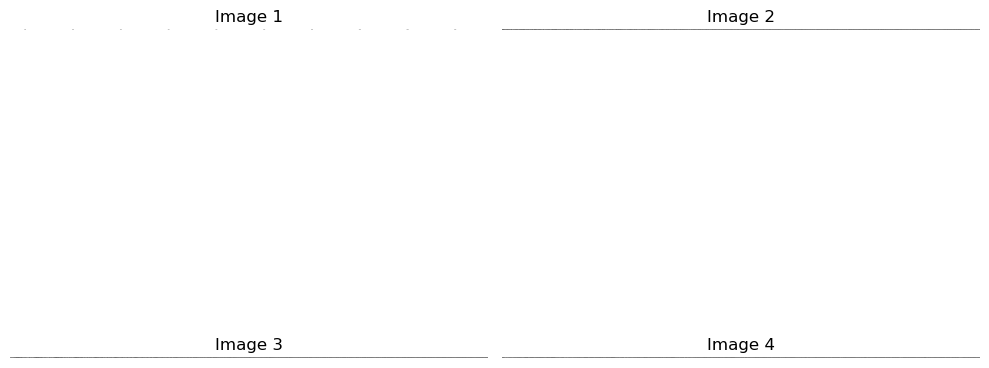

In [31]:
display_generated_images(new_test_df['image segments'].values)

In [32]:
sample_image

# Model Traning

In [33]:
train_transform = v2.Compose([
    v2.Resize(size=(20, 150), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),  
    v2.Normalize(mean=[0.5], std=[0.5])
])

# Testing Transform
test_transform = v2.Compose([
    v2.Resize(size=(20, 150), antialias=True),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),  
    v2.Normalize(mean=[0.5], std=[0.5])
])

img = train_transform(sample_image)
img.shape

torch.Size([4, 20, 150])

In [ ]:
img.size

In [34]:
sample_image = Image.open(new_train_df['image segments'].iloc[6])
train_transform(sample_image)

Image([[[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]],

       [[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]],

       [[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]],

       [[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., 

In [35]:
# define the dataset
class RootVolumeDataset(Dataset):
    def __init__(self, df : pd.DataFrame, transform = None, is_train = True):
        super().__init__()
        self.df = df
        self.transform = transform
        self.is_train = is_train

    def __getitem__(self, index):
        image = Image.open(self.df['image segments'].iloc[index]).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.is_train:
            label = self.df['RootVolume'].iloc[index]

            return image, torch.tensor(label, dtype=torch.float32)

        return image

    def __len__(self):
        return len(self.df)

In [36]:
def seed_everything(seed):
    torch.manual_seed(seed) 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False
    L.pytorch.seed_everything(seed, workers=True)
    
seed_everything(42)

Seed set to 42


In [37]:
train_dataset = RootVolumeDataset(new_train_df, train_transform)
test_dataset = RootVolumeDataset(new_test_df, test_transform, is_train = False)

In [38]:
train_dataset[0][0].shape, train_dataset[0][1]

(torch.Size([3, 20, 150]), tensor(0.9333))

In [39]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [40]:
# simple CNN for the predictions
class RootVolumeRegressor(L.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.lr = lr

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        # Fully Connected Regression Head
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Regression output
        )

        self.criterion = nn.MSELoss()

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        images, targets = batch
        preds = self(images).squeeze()
        loss = self.criterion(preds, targets)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        preds = self(images).squeeze()
        loss = self.criterion(preds, targets)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

model = RootVolumeRegressor()
model

RootVolumeRegressor(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)

# Training using torch lightning ⚡

In [41]:
# 
trainer = L.Trainer(max_epochs = 20)

trainer.fit(model, train_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Reinhard\anaconda3\envs\deeplearning\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
c:\Users\Reinhard\anaconda3\envs\deeplearning\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | conv_layers | Sequential | 23.6 K | 

Epoch 19: 100%|██████████| 25/25 [00:05<00:00,  4.53it/s, v_num=27, train_loss=1.460] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 25/25 [00:05<00:00,  4.51it/s, v_num=27, train_loss=1.460]


In [42]:
def get_model_preds(model, dataloader, device="cuda" if torch.cuda.is_available() else "cpu"):
    preds, targets = [], []
    model.to(device)
    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Predict
            preds.extend(outputs.cpu().numpy().flatten())
            targets.extend(labels.cpu().numpy().flatten())

    return np.array(preds), np.array(targets)

train_preds, target = get_model_preds(model, train_dataloader)

In [43]:
def calculate_rmse(preds, targets):
    """
    Compute Root Mean Squared Error (RMSE) between predictions and ground truth targets.
    """
    preds = np.array(preds) if not isinstance(preds, np.ndarray) else preds
    targets = np.array(targets) if not isinstance(targets, np.ndarray) else targets
    
    return np.sqrt(np.mean((preds - targets) ** 2))

calculate_rmse(train_preds, target)

1.0996052

In [44]:
def get_test_preds(model, dataloader, device="cuda" if torch.cuda.is_available() else "cpu"):
    preds = []
    model.to(device)
    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            images = batch if isinstance(batch, torch.Tensor) else batch[0]
            images = images.to(device)

            outputs = model(images)
            preds.extend(outputs.cpu().numpy().flatten()) 

    return np.array(preds)

test_preds = get_test_preds(model, test_dataloader)

In [45]:
test_df['RootVolume'] = test_preds
test_df.head()

,ID,FolderName,PlantNumber,Side,Start,End,Genotype,Stage,image segments,RootVolume
0,ID_208667_Hnkl8q,L5l1h3kekg,7,L,38,50,IITA-TMS-IBA000070,Early,C:\Users\Reinhard\Documents\computer_vision_pr...,2.249576
1,ID_285249_Jnjvav,Wgutyon8uu,6,R,23,37,TMEB419,Early,C:\Users\Reinhard\Documents\computer_vision_pr...,1.989704
2,ID_697947_Yec6bd,Mylwjeq6tq,3,R,19,42,IBA980581,Early,C:\Users\Reinhard\Documents\computer_vision_pr...,1.940033
3,ID_534638_X3j91f,Pfp24vx905,2,R,27,34,TMEB419,Early,C:\Users\Reinhard\Documents\computer_vision_pr...,2.016273
4,ID_929298_Xvymuz,Mrw7chmalv,4,R,30,43,IBA154810,Early,C:\Users\Reinhard\Documents\computer_vision_pr...,1.935181


In [47]:
submission = test_df[['ID', 'RootVolume']]
submission.to_csv("submission21.csv", index = False)
submission.head()

,ID,RootVolume
0,ID_208667_Hnkl8q,2.249576
1,ID_285249_Jnjvav,1.989704
2,ID_697947_Yec6bd,1.940033
3,ID_534638_X3j91f,2.016273
4,ID_929298_Xvymuz,1.935181


# 🎉 Conclusion

Thank you so much for reading through this notebook! I hope it has provided valuable insights and a solid starting point for the **root volume prediction** task. 🌱 This is just the beginning, and I trust that it will help you make progress in building better predictions for cassava root volumes. 💡

Feel free to share any comments, suggestions, or improvements—I'd love to hear your thoughts!

## ✨ PS:  
### If you found this notebook helpful, please consider giving it an upvote. Your feedback is greatly appreciated! 👍 Happy coding, and good luck! 🚀
